#### Loading Data


In [290]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, LassoCV
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# load dataset
data = pd.read_csv("techSalaries2017.csv")

# Normalize the numerical variables
num_vars = ['totalyearlycompensation', 'basesalary', 'stockgrantvalue', 'bonus', 'yearsofexperience', 'yearsatcompany', 'Age', 'Height', 'SAT', 'GPA']
scaler = StandardScaler()
data[num_vars] = scaler.fit_transform(data[num_vars]) 

# drop unnecessary columns
df = data.drop(['company', 'title', 'location', 'basesalary', 'stockgrantvalue', 'bonus'], axis=1)

# map gender variable to binary
df['gender'] = df['gender'].map({'Male': 0, 'Female': 1})

# create dummy variables for Education and Race columns
education_dummies = pd.get_dummies(df['Education'], prefix='Education', prefix_sep='_')
race_dummies = pd.get_dummies(df['Race'], prefix='Race', prefix_sep='_')

# replace the values in the dummy variables with NaN if the corresponding value in column 22 or 21 is "NA"
education_cols = ['Bachelors_Degree', 'Doctorate_Degree', 'Highschool', 'Masters_Degree', 'Some_College']
df[education_cols] = education_dummies.where(df['Education'].notnull(), np.nan)

race_cols = ['Race_Asian', 'Race_Black', 'Race_Hispanic', 'Race_Two_Or_More', 'Race_White']
df[race_cols] = race_dummies.where(df['Race'].notnull(), np.nan)

# drop the original Education and Race columns
df = df.drop(['Education', 'Race'], axis=1)

# replace missing values with the median of the column
df.fillna(df.median(), inplace=True)

df.columns# split df into training and test sets
X = df.drop('totalyearlycompensation', axis=1)
y = df['totalyearlycompensation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [291]:
df.gender.unique()

array([0., 1.])

In [292]:
df.columns

Index(['totalyearlycompensation', 'yearsofexperience', 'yearsatcompany',
       'gender', 'Masters_Degree', 'Bachelors_Degree', 'Doctorate_Degree',
       'Highschool', 'Some_College', 'Race_Asian', 'Race_White',
       'Race_Two_Or_More', 'Race_Black', 'Race_Hispanic', 'Age', 'Height',
       'Zodiac', 'SAT', 'GPA'],
      dtype='object')

#### Question 1

Best predictor of total annual compensation: yearsofexperience
Variance explained by best predictor alone: 0.17972931326855668
Variance explained by full multiple regression model: 0.2914159229796002
MSE: 0.6965086571523064


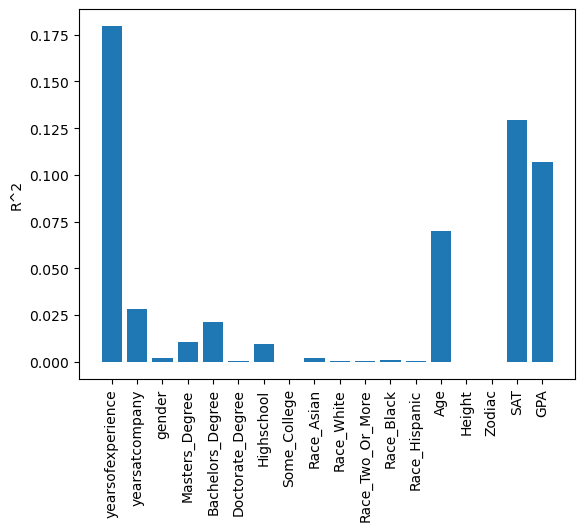

In [293]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# fit multiple linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# make predictions on test set
y_pred = model.predict(X_test)

# calculate R^2 for full model
full_r2 = r2_score(y_test, y_pred)

# fit linear regression model with each variable separately
r2_vals = []
for col in X_train.columns:
    model = LinearRegression()
    model.fit(X_train[[col]], y_train)
    y_pred = model.predict(X_test[[col]])
    r2_vals.append(r2_score(y_test, y_pred))

# get index of variable with highest R^2
best_idx = np.argmax(r2_vals)

# calculate R^2 for best predictor alone
best_r2 = r2_vals[best_idx]

mse_mlr = mean_squared_error(y_test, y_pred)
# print results
print("Best predictor of total annual compensation:", X_train.columns[best_idx])
print("Variance explained by best predictor alone:", best_r2)
print("Variance explained by full multiple regression model:", full_r2)
print('MSE:', mse)
# plot R^2 values for each variable
import matplotlib.pyplot as plt

plt.bar(X_train.columns, r2_vals)
plt.xticks(rotation=90)
plt.ylabel("R^2")
plt.show()


##### 2. Using ridge regression to do the same as in 1): How does the model change or improve compared to OLS? What is the optimal lambda?

Ridge Regression Model:
Optimal lambda: 10.0
MSE: 0.6965086571523064
R^2: 0.291406413290205
Multiple Linear Regression Model:
MSE: 0.6964993096488646
R^2: 0.2914159229796002


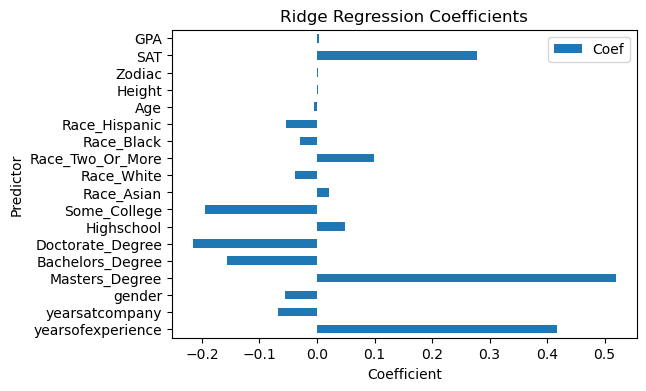

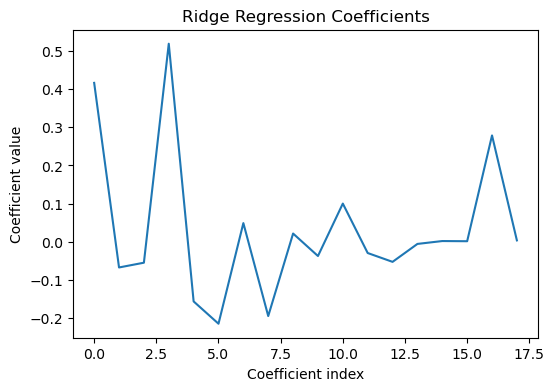

In [294]:
from sklearn.linear_model import RidgeCV

# fit a Ridge regression model to the training data using cross validation to find the optimal lambda
alphas = np.logspace(-4, 4, 9)
ridge = RidgeCV(alphas=alphas, cv=10)
ridge.fit(X_train, y_train)

# evaluate the Ridge regression model on the test data
y_pred = ridge.predict(X_test)
mse_r = mean_squared_error(y_test, y_pred)
r2_r = r2_score(y_test, y_pred)

print('Ridge Regression Model:')
print('Optimal lambda:', ridge.alpha_)
print('MSE:', mse_r)
print('R^2:', r2_r)

# compare to the multiple linear regression model from question 1
mlr = LinearRegression()
mlr.fit(X_train, y_train)
y_pred_mlr = mlr.predict(X_test)
mse_mlr = mean_squared_error(y_test, y_pred_mlr)
r2_mlr = r2_score(y_test, y_pred_mlr)

print('Multiple Linear Regression Model:')
print('MSE:', mse_mlr)
print('R^2:', r2_mlr)

# Get the coefficients from the Ridge model
coef_ridge = pd.DataFrame({'Predictor': X_train.columns, 'Coef': ridge.coef_})

# Create a horizontal bar chart of the coefficients
fig, ax = plt.subplots(figsize=(6, 4))
coef_ridge.plot.barh(x='Predictor', y='Coef', ax=ax)

# Set the axis labels and title
ax.set_xlabel('Coefficient')
ax.set_ylabel('Predictor')
ax.set_title('Ridge Regression Coefficients')

# plot the coefficients for the Ridge regression model
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(range(len(ridge.coef_)), ridge.coef_)
ax.set_xlabel('Coefficient index')
ax.set_ylabel('Coefficient value')
ax.set_title('Ridge Regression Coefficients')
plt.show()


In [ ]:
X.columns

Index(['yearsofexperience', 'yearsatcompany', 'gender', 'Masters_Degree',
       'Bachelors_Degree', 'Doctorate_Degree', 'Highschool', 'Some_College',
       'Race_Asian', 'Race_White', 'Race_Two_Or_More', 'Race_Black',
       'Race_Hispanic', 'Age', 'Height', 'Zodiac', 'SAT', 'GPA'],
      dtype='object')

##### Question 3. Using Lasso regression to do the same as in 1): How does the model change now? How many of the predictor betas are shrunk to exactly 0? What is the optimal lambda now?


In [295]:
# define number of folds for cross-validation
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)


# fit lasso regression model using cross-validation to tune alpha
alphas = np.logspace(-3, 0, 100)
lasso = LassoCV(alphas=alphas, cv=kfolds)
lasso.fit(X_train, y_train)

# predict on test set and calculate performance metrics
y_pred_lasso = lasso.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

# print performance metrics for all models
print("Multiple Linear Regression Model:")
print("MSE:", mse_mlr)
print("R^2:", r2_mlr)

print("Ridge Regression Model:")
print("Optimal lambda:", ridge.alpha_)
print("MSE:", mse_r)
print("R^2:", r2_r)

print("Lasso Regression Model:")
print("Optimal alpha:", lasso.alpha_)
print("MSE:", mse_lasso)
print("R^2:", r2_lasso)

Multiple Linear Regression Model:
MSE: 0.6964993096488646
R^2: 0.2914159229796002
Ridge Regression Model:
Optimal lambda: 10.0
MSE: 0.6965086571523064
R^2: 0.291406413290205
Lasso Regression Model:
Optimal alpha: 0.001
MSE: 0.6966704619042633
R^2: 0.2912418011086356


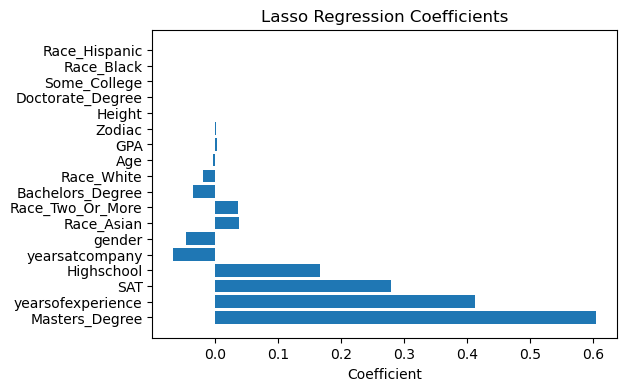

In [296]:
# create a dictionary of feature names and their corresponding coefficients
lasso_coefs = dict(zip(X.columns, lasso.coef_))

# sort the dictionary by absolute value of the coefficients
lasso_coefs = {k: v for k, v in sorted(lasso_coefs.items(), key=lambda item: abs(item[1]), reverse=True)}


# create a bar chart of the coefficients

plt.figure(figsize=(6, 4))
plt.barh(range(len(lasso_coefs)), list(lasso_coefs.values()))
plt.yticks(range(len(lasso_coefs)), list(lasso_coefs.keys()))
plt.xlabel('Coefficient')
plt.title('Lasso Regression Coefficients')
plt.show()


In [297]:
# Get coefficients and count number of non-zero coefficients
lasso_coefs = dict(zip(X.columns, lasso.coef_))
num_important_vars = sum(abs(lasso.coef_) > 0)
print (num_important_vars)

14


#### question 4

              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94     11161
         1.0       0.00      0.00      0.00      1368

    accuracy                           0.89     12529
   macro avg       0.45      0.50      0.47     12529
weighted avg       0.79      0.89      0.84     12529



/Users/chloe/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chloe/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chloe/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


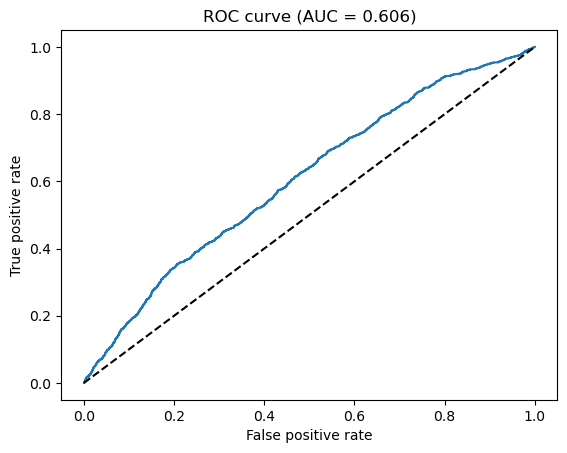

In [298]:



# Split data into training and test sets
X = df[['Age', 'yearsofexperience', 'Masters_Degree', 'Bachelors_Degree', 'Doctorate_Degree', 'Highschool', 'Some_College', 'Race_Asian', 'Race_White', 'Race_Two_Or_More', 'Race_Black', 'Race_Hispanic', 'totalyearlycompensation']]
y = df['gender']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit logistic regression model
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

# Predict probabilities of each class for test data
probs = logreg.predict_proba(X_test)

# Evaluate performance of model
print(classification_report(y_test, logreg.predict(X_test)))
fpr, tpr, _ = roc_curve(y_test, probs[:, 1])
auc = roc_auc_score(y_test, probs[:, 1])


# Plot ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (AUC = {:.3f})'.format(auc))
plt.show()


In [300]:
# Print coefficients
print('Coefficients:', logreg.coef_)

# Print intercept
print('Intercept:', logreg.intercept_)

# Predict test set outcomes
y_pred = logreg.predict(X_test)

# Print classification report
print('Classification report:')
print(classification_report(y_test, y_pred))

# Print confusion matrix
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

# Calculate and print AUC
y_prob = logreg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

Coefficients: [[-0.01527505 -0.17987172  0.36255223  0.591506   -1.25156072  0.19423114
   0.06292417 -0.48567913  0.00515673  0.12166352  0.44571978 -0.12720807
  -0.10722317]]
Intercept: [-2.00464754]
Classification report:
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94     11161
         1.0       0.00      0.00      0.00      1368

    accuracy                           0.89     12529
   macro avg       0.45      0.50      0.47     12529
weighted avg       0.79      0.89      0.84     12529

Confusion matrix:
[[11161     0]
 [ 1368     0]]


/Users/chloe/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chloe/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/chloe/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TypeError: 'numpy.float64' object is not callable

In [301]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Load data and select predictor variables
df = pd.read_csv('techSalaries2017.csv')
X = df[['yearsofexperience', 'Age', 'Height', 'SAT', 'GPA']].fillna(0)

# Create outcome variable (high vs. low pay) by median split
y = (df['totalyearlycompensation'] >= df['totalyearlycompensation'].median()).astype(int)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit logistic regression model
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Generate predicted probabilities and actual labels for testing set
y_prob = clf.predict_proba(X_test)[:,1]
y_pred = clf.predict(X_test)

# Calculate accuracy and AUC
acc = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

# Print results
print('Accuracy:', acc)
print('AUC:', auc)
print('Coefficients:', clf.coef_)


Accuracy: 0.6857690158831511
AUC: 0.7485241731602843
Coefficients: [[ 0.15099692 -0.00594129 -0.06477223  0.00327679 -0.00097216]]


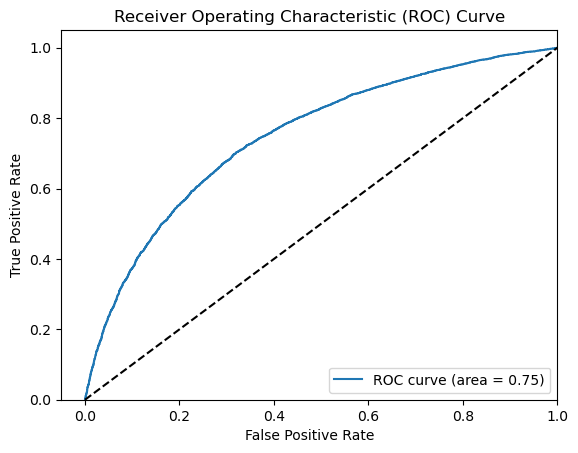

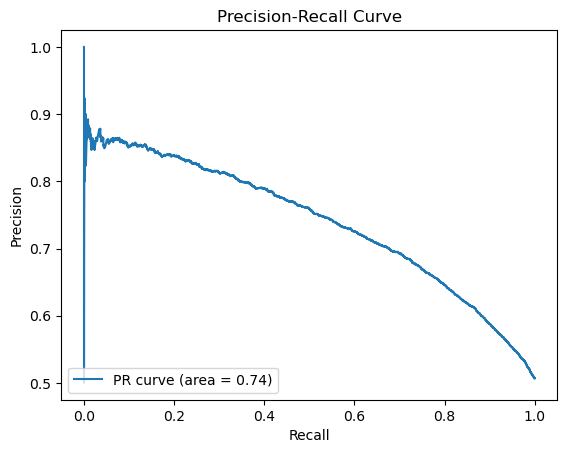

In [302]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

# Load data
data = pd.read_csv('techSalaries2017.csv')

# Create binary outcome variable based on median split of total yearly compensation
median_comp = data['totalyearlycompensation'].median()
data['high_earner'] = np.where(data['totalyearlycompensation'] >= median_comp, 1, 0)

# Select predictor variables and split data into training and testing sets
X = data[['yearsofexperience', 'Age', 'Height', 'SAT', 'GPA']]
y = data['high_earner']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit logistic regression model and generate predicted probabilities and actual labels for testing set
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_prob = logreg.predict_proba(X_test)[:, 1]
y_pred = logreg.predict(X_test)

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Compute Precision-Recall curve and AUC
precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

# Plot Precision-Recall curve
plt.plot(recall, precision, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


In [304]:
# Print coefficients
print('Coefficients:', logreg.coef_)

# Print intercept
print('Intercept:', logreg.intercept_)

# Predict test set outcomes
y_pred = logreg.predict(X_test)

# Print classification report
print('Classification report:')
print(classification_report(y_test, y_pred))

# Print confusion matrix
print('Confusion matrix:')
print(confusion_matrix(y_test, y_pred))

# Calculate and print AUC
y_prob = logreg.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

Coefficients: [[ 0.15099692 -0.00594129 -0.06477223  0.00327679 -0.00097216]]
Intercept: [-0.00175345]
Classification report:
              precision    recall  f1-score   support

           0       0.66      0.73      0.70      6181
           1       0.71      0.64      0.67      6348

    accuracy                           0.69     12529
   macro avg       0.69      0.69      0.69     12529
weighted avg       0.69      0.69      0.69     12529

Confusion matrix:
[[4539 1642]
 [2295 4053]]
AUC: 0.7485241731602843


/Users/chloe/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Salary Shapiro-Wilk test: p-value = 0.0
Age Shapiro-Wilk test: p-value = 0.0
Height Shapiro-Wilk test: p-value = 0.6899451017379761


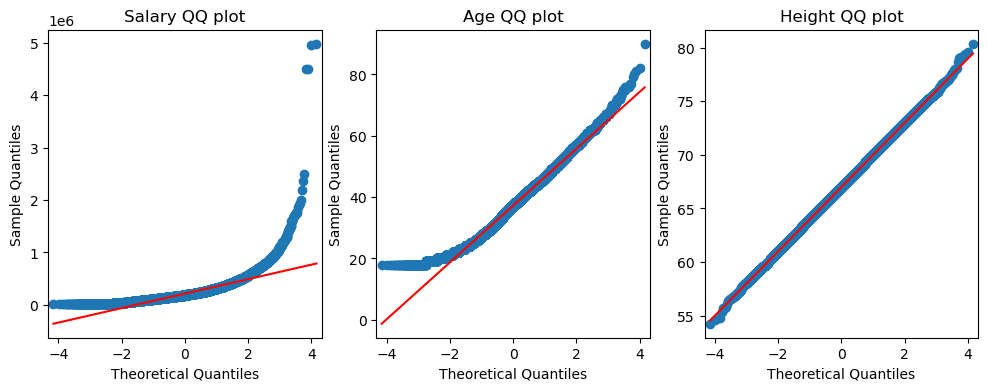

In [312]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot

# Load data
df = pd.read_csv("techSalaries2017.csv")

# Extract relevant columns
salary = df["totalyearlycompensation"].dropna()
age = df["Age"].dropna()
height = df["Height"].dropna()

# Shapiro-Wilk test for normality
stat, p = shapiro(salary)
print("Salary Shapiro-Wilk test: p-value = {}".format(p))

stat, p = shapiro(age)
print("Age Shapiro-Wilk test: p-value = {}".format(p))

stat, p = shapiro(height)
print("Height Shapiro-Wilk test: p-value = {}".format(p))

# QQ plots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

qqplot(salary, line="s", ax=axs[0])
axs[0].set_title("Salary QQ plot")

qqplot(age, line="s", ax=axs[1])
axs[1].set_title("Age QQ plot")

qqplot(height, line="s", ax=axs[2])
axs[2].set_title("Height QQ plot")

plt.show()


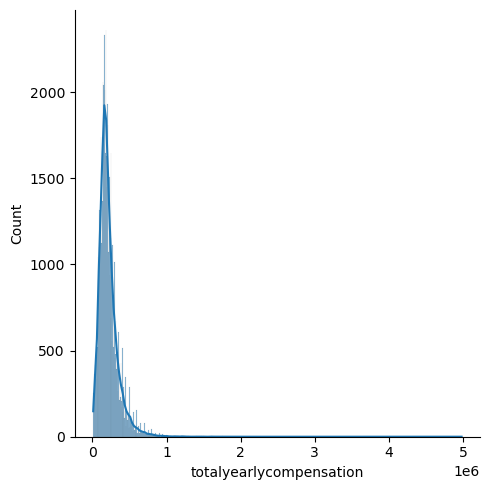

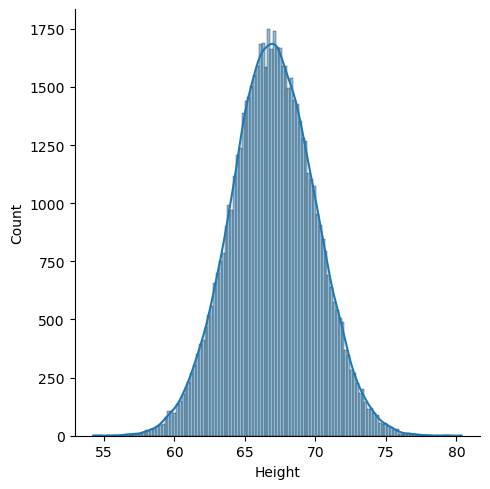

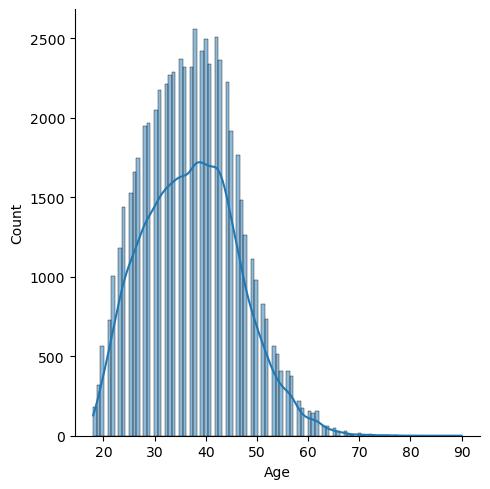

In [313]:
# Check distribution of salary, height, and age
sns.displot(data, x="totalyearlycompensation", kde=True)
sns.displot(data, x="Height", kde=True)
sns.displot(data, x="Age", kde=True)

Based on the Shapiro-Wilk test results, it can be seen that salary and age are not normally distributed, while height is normally distributed. Both salary and age are right-skewed, which means that most of the data is concentrated towards the lower end of the range, and there are some extreme values that drag the mean upwards. This is common in income data and data related to human lifetimes, as there are upper limits to how much a person can earn or how long they can live.

The p-values for the Shapiro-Wilk test for both salary and age are 0.0, indicating strong evidence against the null hypothesis of normality. On the other hand, the p-value for height is 0.69, which is high enough to not reject the null hypothesis of normality at conventional levels of significance.

It is not surprising to see that salary and age are not normally distributed, as this is a common characteristic of these types of data. However, the normality of height may be unexpected, as height is a physical characteristic that is often assumed to be normally distributed. This finding may have implications for statistical analyses that assume normality, such as hypothesis tests and confidence intervals.

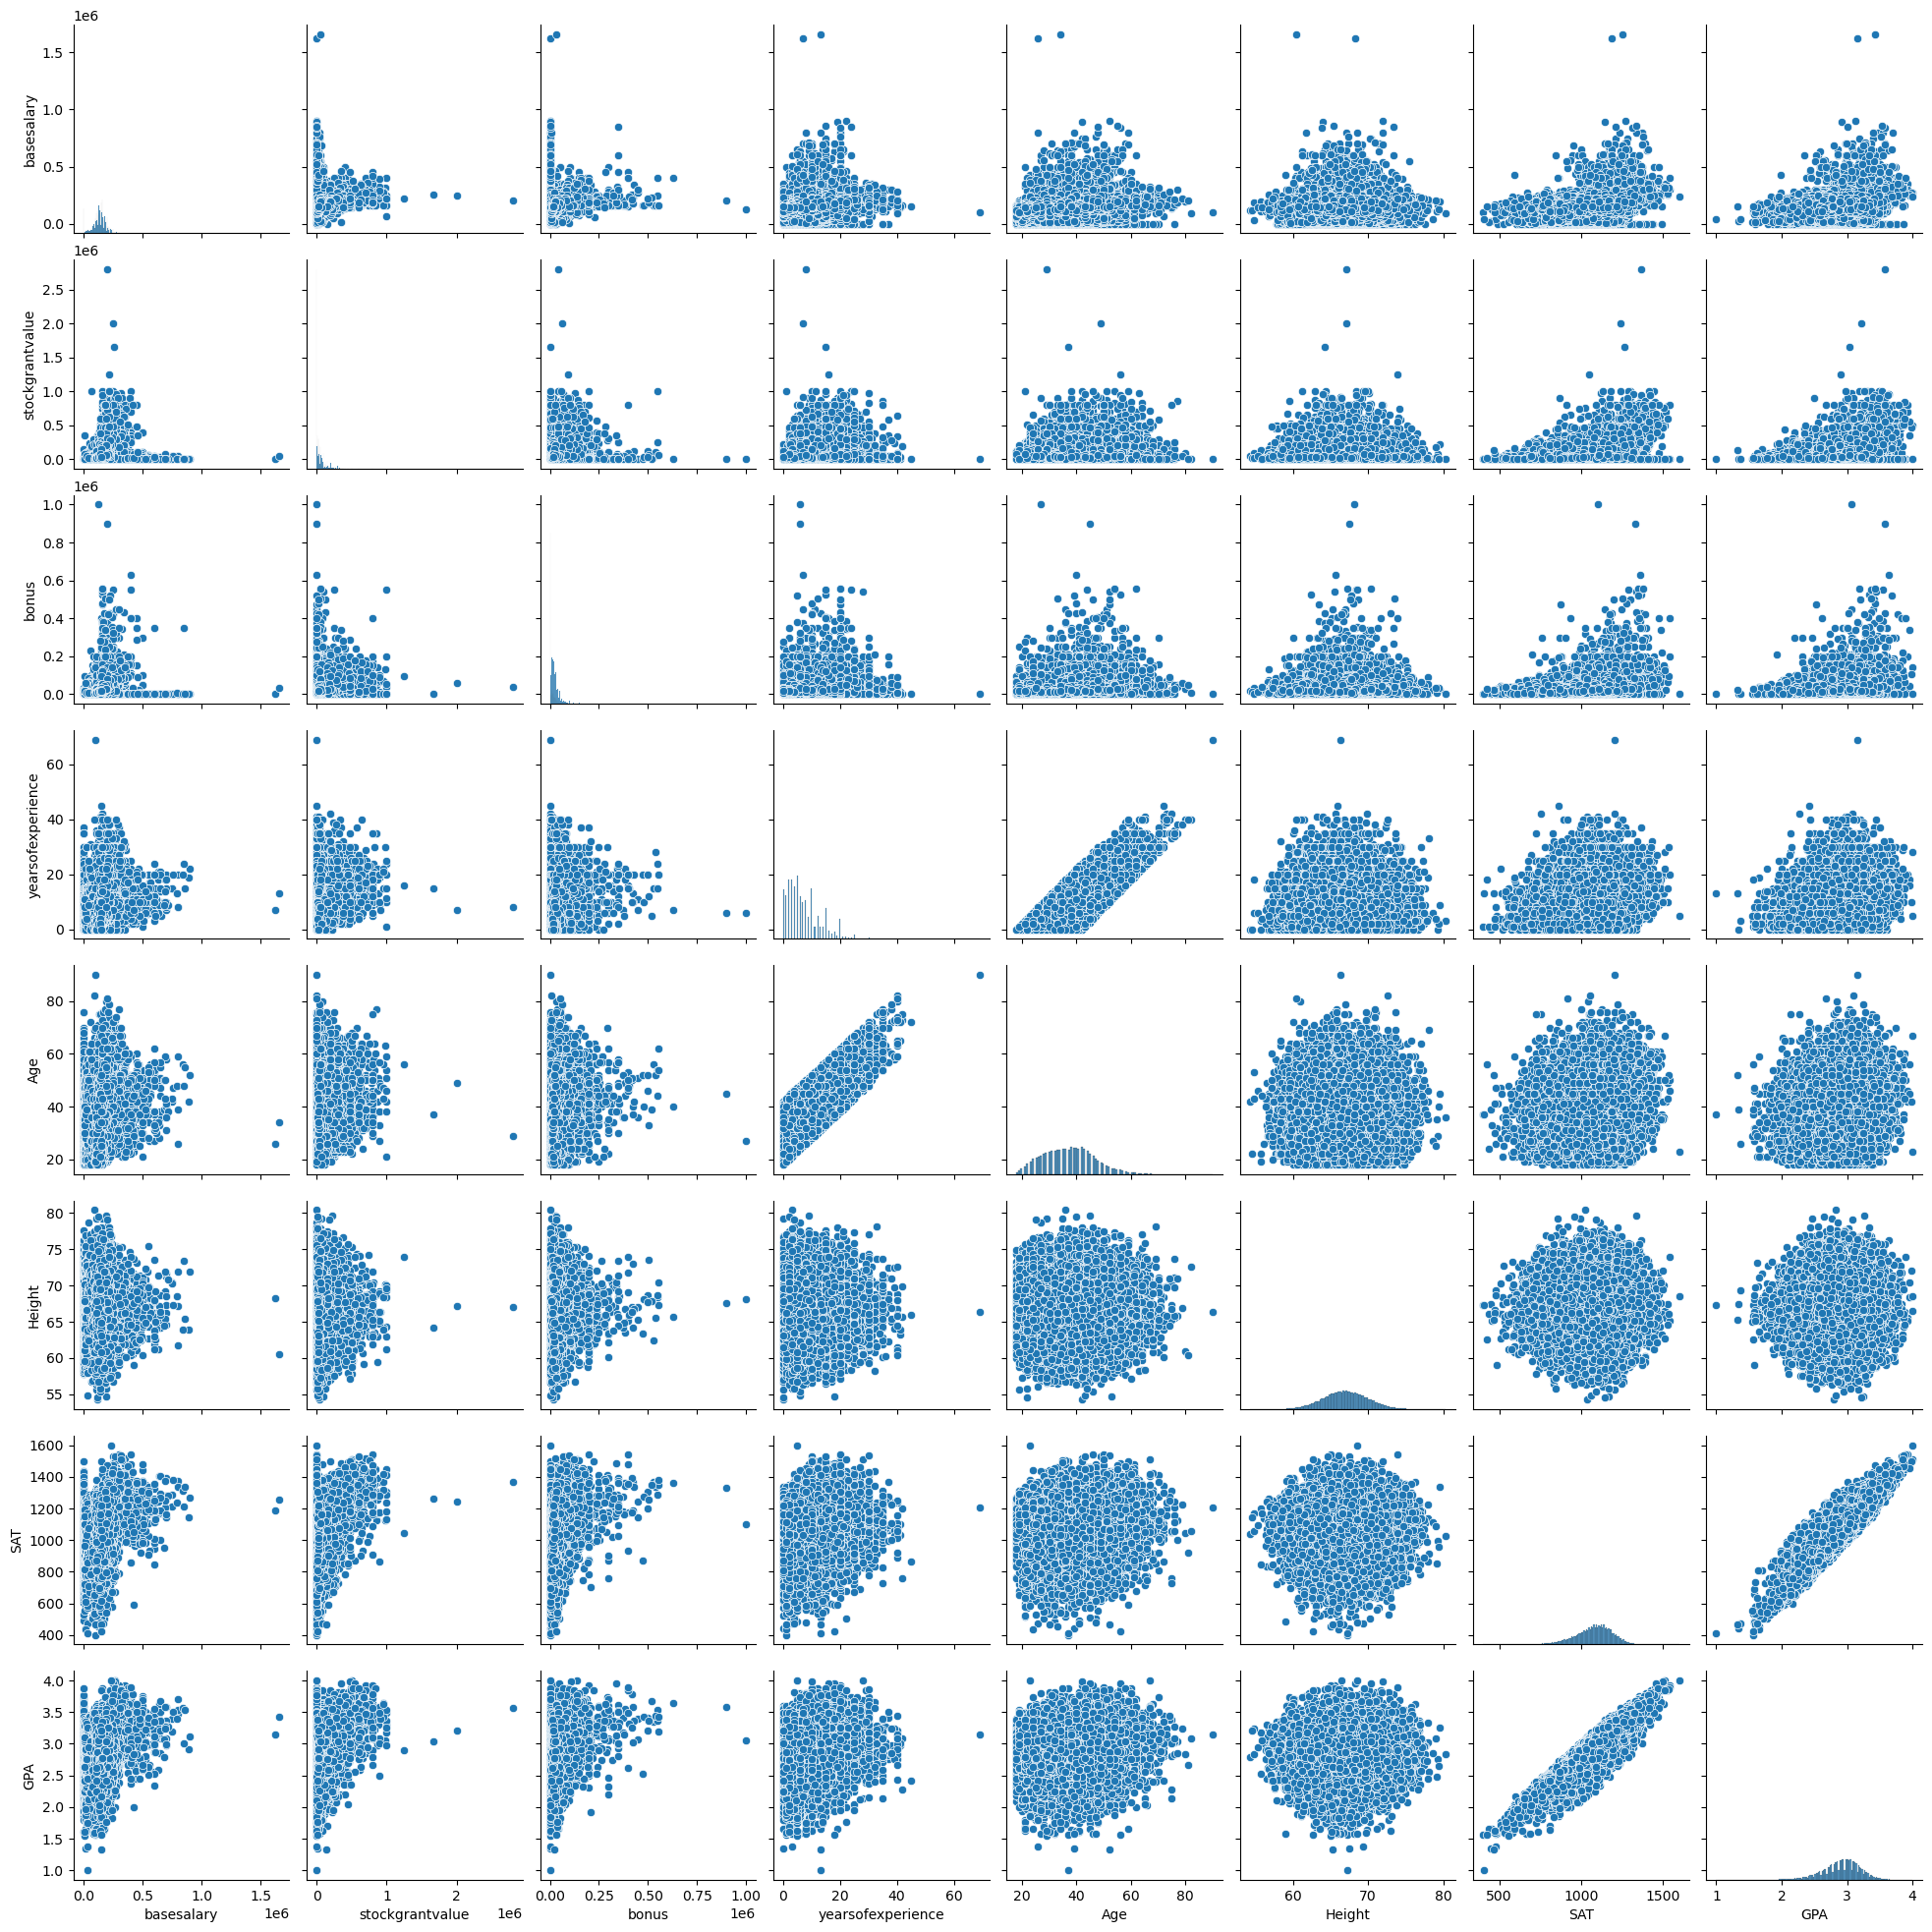

In [321]:


sns.pairplot(data[['basesalary', 'stockgrantvalue', 'bonus', 'yearsofexperience', 'Age', 'Height', 'SAT', 'GPA']])


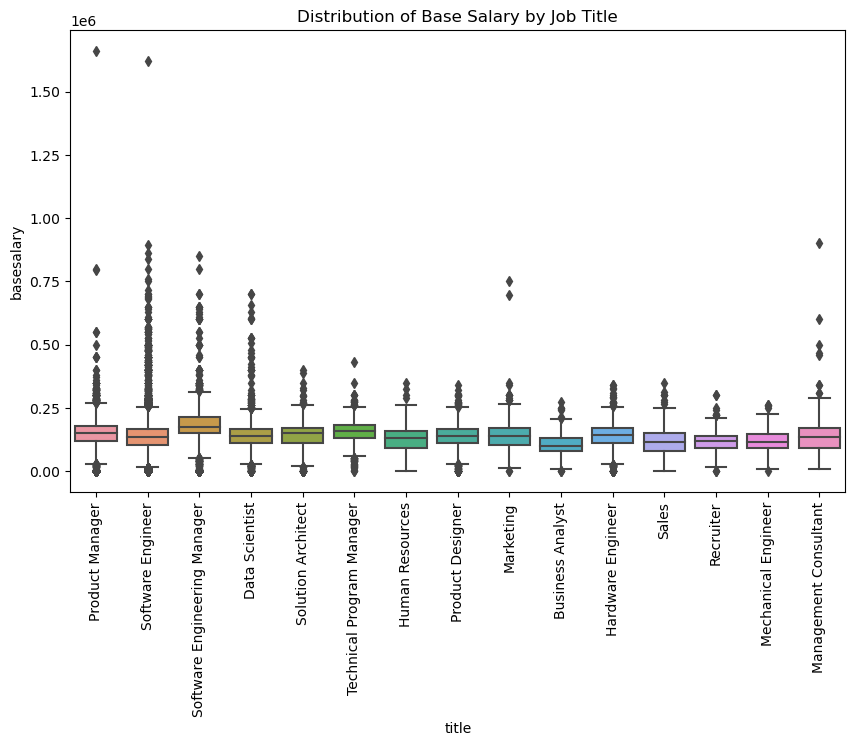

In [320]:


fig, ax = plt.subplots(figsize=(10,6))
sns.boxplot(x='title', y='basesalary', data=data, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_title('Distribution of Base Salary by Job Title')
plt.show()
